<a href="https://colab.research.google.com/github/Andre7195/ArquiSoftware/blob/main/ArquiSoftware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import sklearn
import keras
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Base = '/content/drive/MyDrive/Dataset_Arqui'
Train = '/content/drive/MyDrive/Dataset_Arqui/Train'
Test = '/content/drive/MyDrive/Dataset_Arqui/Test'
test_sal ='/content/drive/MyDrive/Dataset_Arqui/Test/Healthy'
test_tiz ='/content/drive/MyDrive/Dataset_Arqui/Test/Early_Blight'

train_sal ='/content/drive/MyDrive/Dataset_Arqui/Train/Healthy'
train_tiz ='/content/drive/MyDrive/Dataset_Arqui/Train/Early_Blight'

In [4]:
num_sal_train = len(os.listdir(train_sal))
num_tiz_train = len(os.listdir(train_tiz))
num_sal_test = len(os.listdir(test_sal))
num_tiz_test= len(os.listdir(test_tiz))

In [5]:
print("Numero de hojas saludables (train): ",num_sal_train)
print("Numero de hojas infectadas tizon (train): ",num_tiz_train)
print("--")
print("Numero de hojas saludables (test):", num_sal_test)
print("Numero de hojas infectadas tizon (test):",num_tiz_test)

print("La partición del dataset es 80 - 20")

Numero de hojas saludables (train):  3000
Numero de hojas infectadas tizon (train):  3000
--
Numero de hojas saludables (test): 750
Numero de hojas infectadas tizon (test): 750
La partición del dataset es 80 - 20


In [6]:
IMG_SHAPE  = 224
batch_size = 64

image_shape = 224

In [7]:

image_gen_train = ImageDataGenerator(validation_split=0.1)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = '/content/drive/MyDrive/Dataset_Arqui/Train',
subset ="training",
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'categorical')

valid_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = '/content/drive/MyDrive/Dataset_Arqui/Train',
subset ="validation",
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'categorical')

image_gen_test = ImageDataGenerator()
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory='/content/drive/MyDrive/Dataset_Arqui/Test',
shuffle = False,
target_size=(image_shape, image_shape),
class_mode='categorical')


Found 5400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [8]:
pre_trained_model = tf.keras.applications.VGG16(
    include_top=False,  
    weights="imagenet",   
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=max,
    classes=2,
    classifier_activation="softmax") 

58889256/58889256 [==============================] - 2s 0us/step


In [9]:
pre_trained_model.trainable = False

for layer in pre_trained_model.layers: #mantener las capas de vgg16, transfer learning
  print(layer.name)
  layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [10]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)



In [11]:
model = tf.keras.Model(pre_trained_model.input, x)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,loss = 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
vgg_classifier = model.fit(train_data_gen,
  epochs = 10,
  batch_size = batch_size,
  steps_per_epoch = 30,
  validation_data=valid_data_gen,
  verbose = 1)

Epoch 1/10
30/30 [==============================] - 762s 25s/step - loss: 11.2366 - accuracy: 0.7417 - val_loss: 2.0795 - val_accuracy: 0.8683
Epoch 2/10
30/30 [==============================] - 322s 11s/step - loss: 1.1851 - accuracy: 0.9151 - val_loss: 0.8881 - val_accuracy: 0.9083
Epoch 3/10
30/30 [==============================] - 226s 8s/step - loss: 0.4083 - accuracy: 0.9552 - val_loss: 0.5934 - val_accuracy: 0.9333
Epoch 4/10
30/30 [==============================] - 137s 5s/step - loss: 0.2096 - accuracy: 0.9677 - val_loss: 0.5180 - val_accuracy: 0.9417
Epoch 5/10
30/30 [==============================] - 93s 3s/step - loss: 0.1341 - accuracy: 0.9703 - val_loss: 0.4437 - val_accuracy: 0.9383
Epoch 6/10
30/30 [==============================] - 68s 2s/step - loss: 0.0953 - accuracy: 0.9776 - val_loss: 0.5317 - val_accuracy: 0.9283
Epoch 7/10
30/30 [==============================] - 50s 2s/step - loss: 0.1042 - accuracy: 0.9798 - val_loss: 0.2723 - val_accuracy: 0.9517
Epoch 8/10
30

In [13]:
loss0,accuracy0 = model.evaluate(test_data_gen)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

24/24 [==============================] - 740s 32s/step - loss: 0.3780 - accuracy: 0.9467
loss: 0.38
accuracy: 0.95


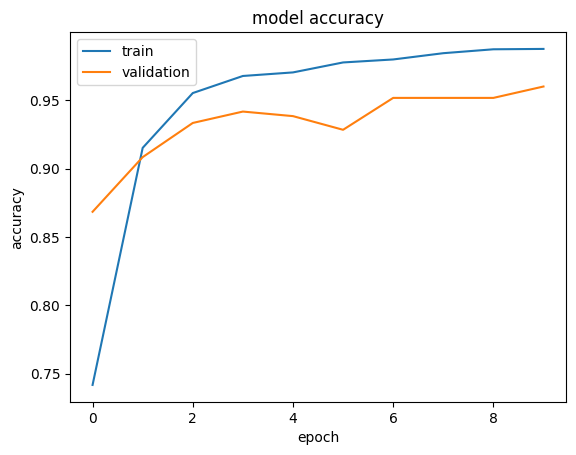

In [14]:
plt.plot(vgg_classifier.history['accuracy'])
plt.plot(vgg_classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

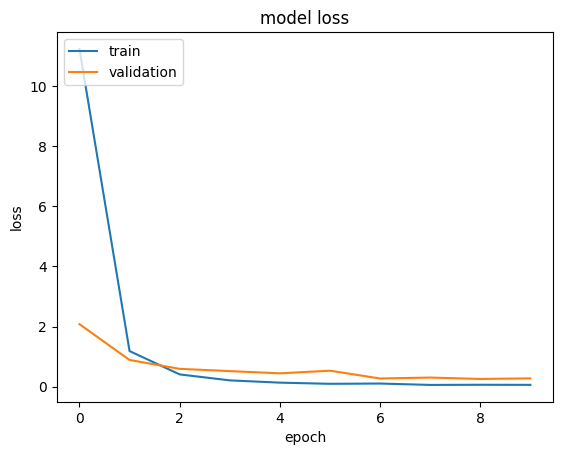

In [15]:
plt.plot(vgg_classifier.history['loss'])
plt.plot(vgg_classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
predictions = model.predict(test_data_gen)

predicted_classes = np.argmax(predictions, axis=1)

print(test_data_gen.class_indices)

print(confusion_matrix(test_data_gen.classes, predicted_classes))

print(classification_report(test_data_gen.classes, predicted_classes))

24/24 [==============================] - 7s 282ms/step
{'Early_Blight': 0, 'Healthy': 1}
[[716  34]
 [ 46 704]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       750
           1       0.95      0.94      0.95       750

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [19]:
model.save('/content/VGG16',save_format='h5')

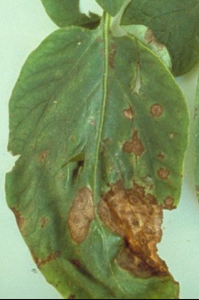

1/1 [==============================] - 0s 26ms/step
[[1. 0.]]


In [33]:
from PIL import Image
from google.colab.patches import cv2_imshow
from numpy import asarray
import PIL
import cv2


path = '/content/drive/MyDrive/Individuales/EarlyBlight.PNG'
imagen = cv2.imread(path)
cv2_imshow(imagen)

def prepare(filepath):
  IMG_SIZE = 224
  img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)

predictions = (model.predict([prepare(path)]) > 0.5).astype("float")
print (predictions)

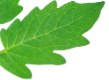

1/1 [==============================] - 0s 27ms/step
[[0. 1.]]


In [34]:
from PIL import Image
from google.colab.patches import cv2_imshow
from numpy import asarray
import PIL
import cv2


path = '/content/drive/MyDrive/Individuales/Sana.JPG'
imagen = cv2.imread(path)
cv2_imshow(imagen)

def prepare(filepath):
  IMG_SIZE = 224
  img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)

predictions = (model.predict([prepare(path)]) > 0.5).astype("float")
print (predictions)

In [9]:

!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/Andre7195/ArquiSoftware.git
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
On branch main
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
fatal: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address
